In [1]:
# Pull in data and save it to a DataFrame

import pandas as pd

# Replace this with the path to your CSV file
file_path = '/Users/christopherfrye/Downloads/fraud_detection.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

,Threshold,Fraud Caught,Fraud Missed,Customers Blocked,Financial Impact (€)
2,0.1000,39,62,45,64250
3,0.1667,38,63,36,64800
4,0.2000,35,66,21,67050
5,0.4167,33,68,13,68650
6,0.7000,28,73,6,73300
7,1.0000,14,87,0,87000
1,0.0006,101,0,104679,5233950
0,0.0000,101,0,104740,5237000


/var/folders/b5/djh8x2mx1c527pvc3mz53dyh0000gp/T/ipykernel_31946/785838406.py:73: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  plt.tight_layout()
/Users/christopherfrye/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/christopherfrye/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/christopherfrye/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


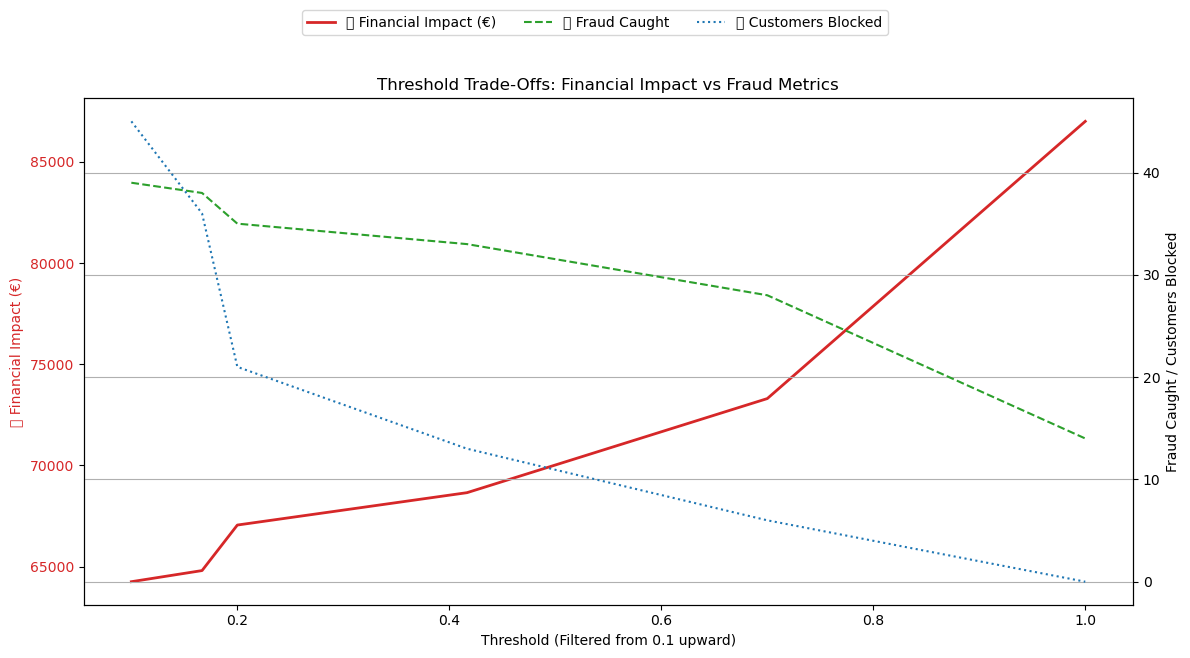

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Step 1: Clean action strings
df['actions_clean'] = df['actions_str'].apply(lambda x: " ".join(x.split()) if isinstance(x, str) else "")

# Step 2: TF-IDF features (1-3 grams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = vectorizer.fit_transform(df['actions_clean'])
y = df['is_fraud']

# Step 3: Train Decision Tree
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf.fit(X_tfidf, y)

# Step 4: Predict and PR curve
y_scores = clf.predict_proba(X_tfidf)[:, 1]
prec, rec, thresholds = precision_recall_curve(y, y_scores)

# Step 5: Financial impact table
total_frauds = y.sum()
impacts = []
for t in thresholds:
    preds = (y_scores >= t).astype(int)
    fraud_caught = ((preds == 1) & (y == 1)).sum()
    fraud_missed = total_frauds - fraud_caught
    customers_blocked = ((preds == 1) & (y == 0)).sum()
    financial_impact = fraud_missed * 1000 + customers_blocked * 50
    impacts.append({
        "Threshold": round(t, 4),
        "Fraud Caught": fraud_caught,
        "Fraud Missed": fraud_missed,
        "Customers Blocked": customers_blocked,
        "Financial Impact (€)": financial_impact
    })

impact_df = pd.DataFrame(impacts)

# Step 6: Show table
display(impact_df.sort_values("Financial Impact (€)"))

# Step 7: Filter for plotting (threshold ≥ 0.1, exclude 0.0000 & 0.0006)
filtered_impact_df = impact_df[
    (impact_df['Threshold'] >= 0.1000) &
    (~impact_df['Threshold'].isin([0.0000, 0.0006]))
].sort_values("Threshold")

# Step 8: Dual-Y plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Threshold (Filtered from 0.1 upward)')
ax1.set_ylabel('💸 Financial Impact (€)', color='tab:red')
ax1.plot(filtered_impact_df['Threshold'], filtered_impact_df['Financial Impact (€)'],
         color='tab:red', label='💸 Financial Impact (€)', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Fraud Caught / Customers Blocked', color='black')
ax2.plot(filtered_impact_df['Threshold'], filtered_impact_df['Fraud Caught'],
         color='tab:green', linestyle='--', label='✅ Fraud Caught')
ax2.plot(filtered_impact_df['Threshold'], filtered_impact_df['Customers Blocked'],
         color='tab:blue', linestyle=':', label='🚫 Customers Blocked')
ax2.tick_params(axis='y', labelcolor='black')

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.title('Threshold Trade-Offs: Financial Impact vs Fraud Metrics')
plt.grid(True)
plt.tight_layout()
plt.show()